# Tilt and Compliance Corrections for OBS Data: Continuous
### Xiaotao Yang @ Harvard University
This notebook contains examples of compliance corrections using data downloaded from IRIS. The functions for tilt and compliance corrections are in module seisgo.obsmaster.
### References:
Bell, S. W., D. W. Forsyth, & Y. Ruan (2015), Removing Noise from the Vertical Component Records of Ocean-Bottom Seismometers: Results from Year One of the Cascadia Initiative, Bull. Seismol. Soc. Am., 105(1), 300-313, doi:10.1785/0120140054.

Tian, Y., & M. H. Ritzwoller (2017), Improving ambient noise cross-correlations in the noisy ocean bottom environment of the Juan de Fuca plate, Geophys. J. Int., 210(3), 1787-1805, doi:10.1093/gji/ggx281.

Helen A Janiszewski, James B Gaherty, Geoffrey A Abers, Haiying Gao, Zachary C Eilon, Amphibious surface-wave phase-velocity measurements of the Cascadia subduction zone, Geophysical Journal International, Volume 217, Issue 3, June 2019, Pages 1929–1948, https://doi.org/10.1093/gji/ggz051

## Step 0. Load needed packages.
Some functions are imported from the utils.py and the obsmaster.py.

In [1]:
#import needed packages.
from seisgo import utils
from seisgo import obsmaster as obs
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.core import Stream,Trace
from IPython.display import clear_output
from obspy.clients.fdsn import Client

## Step 1. Set global parameters for downloading
Set downloading and saving parameters. We download the same data as Figure 5 in Janiszewski et al. (2019).The following figure is from their paper for reference.
Earthquake information:
M 7.1 - Vanuatu
2012-02-02 13:34:40 (UTC)17.827°S 167.133°E 23.0 km depth

![title](embededfigs/JaniszewskiGJI2019Fig5.png)

In [2]:
# get data from IRIS web service

net="7D"
stalist=["FN07A","G30A"]#["G03A","J35A","J44A","J65A"]
starttime = obspy.UTCDateTime("2012_02_02_0_0_0")       
endtime   = obspy.UTCDateTime("2012_02_03_0_0_0")
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0

"""
parameters for processing
"""
rmresp=True #remove instrument response
# parameters for butterworth filter
samp_freq=10
pfreqmin=0.002
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.95*pfreqmin;f2=pfreqmin
if 1.05*pfreqmax > 0.48*samp_freq:
    f3 = 0.45*samp_freq
    f4 = 0.48*samp_freq
else:
    f3 = pfreqmax
    f4= 1.05*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=obs.maxcompfreq(d,iplot=False)

## Step 2a. Download data and do correction
We download all four components of the OBS data for the example stations. In this example, we separate each step in removing the tilt and compliance noise. We use this example to show the procedure, performance, and the choice of different correction parameters.

In [3]:
"""
Loop through stations
"""
runthisstep=False
correctevent=False #change to True to correct the earthquake waveforms with a relatively short duration.
normalizecorrectionplot=False
if runthisstep:
    for ista in stalist:
        t0=time.time()
        """
        a. Downloading data that will be used to compute the transfer functions.
        """
        tr1,tr2,trZ,trP = obs.getdata(net,ista,starttime,endtime,samp_freq=samp_freq,
                                      plot=False,rmresp=rmresp,pre_filt=pre_filt)
        ta=time.time() - t0
        """
        b. Compute spectra of the continuous data through sliding windows.
        """
        window=7200
        overlap=0.3
        #compute spectra for all traces.
        spectra=obs.getspectra(tr1,tr2,trZ,trP,pd=[0.004, 0.2],window=window,overlap=overlap,
                              QC=True,fig=False,save=True,debug=False)

        tb=time.time() - t0 - ta
        """
        c. Compute transfer functions 
        """
        #compute transfer functions for all possible combinations
        transferfunc=obs.gettransferfunc(spectra['auto'],spectra['cross'],spectra['rotation'])

        tc=time.time() - t0 - ta - tb

        """
        d. Get test event data
        """
        if correctevent:
            evstarttime=obspy.UTCDateTime("2012_02_02_13_00_0")
            evendtime=evstarttime+2*window
            etr1,etr2,etrZ,etrP = obs.getdata(net,ista,evstarttime,evendtime,samp_freq=samp_freq,
                                              plot=False,rmresp=rmresp,pre_filt=pre_filt)
        td=time.time() - t0 - ta - tb - tc
        """
        e. Do corrections and plot the comparison
        """
        overlaps=[0.3]
        tapers=[0.1]
        correctdictall=[]
        for k in range(len(overlaps)):
            if correctevent:
                correctdict = obs.docorrection(etr1,etr2,etrZ,etrP,transferfunc,
                                               overlap=overlaps[k],taper=tapers[k])
                obs.plotcorrection(etrZ,correctdict,normalize=normalizecorrectionplot,freq=[0.005,0.1], 
                                   xlimit=(2000,9200),size=(12,13),save=True,form='png')
            else:
                correctdict = obs.docorrection(tr1,tr2,trZ,trP,transferfunc,
                                               overlap=overlaps[k],taper=tapers[k])
                obs.plotcorrection(trZ,correctdict,normalize=normalizecorrectionplot,freq=[0.005,0.1],
                                   size=(12,13),save=True,form='png')
            correctdictall.append(correctdict)

        te1=(time.time() - t0 - ta - tb - tc - td)/len(overlaps)

        print('all cpu times:')
        print(ta,tb,tc,td)
        print(te1)

    #     """
    #     f. Plot overlapping waveforms for all correction options
    #     """
    #     for key in correctdict.keys():
    #         d1=trZ.copy()
    #         d1.data=correctdictall[0][key]
    #         d2=trZ.copy()
    #         d2.data=correctdictall[1][key]

    #         utils.plot_trace((d1,d2),\
    #                    size=(10,4),datalabels=["no overlap","0.1 OL, 0.05 TP"],\
    #                    title=net+"."+ista+":corrected vertical:"+key,freq=[0.05,0.1],\
    #                    xlimit=(6200,7500),mode="overlap",ylabels=["displacement (m)"],\
    #                    outfile=net+"."+ista+"_comparison_"+key+".png",colors=['k','b','r'])
    

## Step 2b. Download data and do correction through a wrapper
Same as 2a but uses the wrapper function instead of explicitly separating each step. We only correct for the continuous daily data, not the earthquake waveforms.

station 7D.FN07A --> pressure channel: HDH
station 7D.FN07A --> seismic channels: HH1, HH2, HHZ
  downsamping from 125 to 10
  removing response using inv for 7D.FN07A.HH1
  removing response using inv for 7D.FN07A.HH2
  removing response using inv for 7D.FN07A.HHZ
  removing response using inv for 7D.FN07A.HDH
Merging multiple corrected segments.
windows connect at the following times:
[   720.   6480.  12240.  18000.  23760.  29520.  35280.  41040.  46800.
  52560.  58320.  64080.  69840.  75600.  79920.]
all cpu times:
72.34091305732727 8.583954811096191
  saving raw data to 7D.FN07A_2012.33T0-0-0_LEN86399.9s_raw.h5
  saving corrected data to 7D.FN07A_2012.33T0-0-0_LEN86399.9s_corrected.h5
2 Trace(s) in Stream:
7D.FN07A..HHZ | 2012-02-02T00:00:00.000000Z - 2012-02-02T23:59:59.900000Z | 10.0 Hz, 864000 samples
7D.FN07A..HHZ | 2012-02-02T00:00:00.000000Z - 2012-02-02T23:59:59.900000Z | 10.0 Hz, 864000 samples
station 7D.G30A --> pressure channel: BDH
station 7D.G30A --> seismic channe

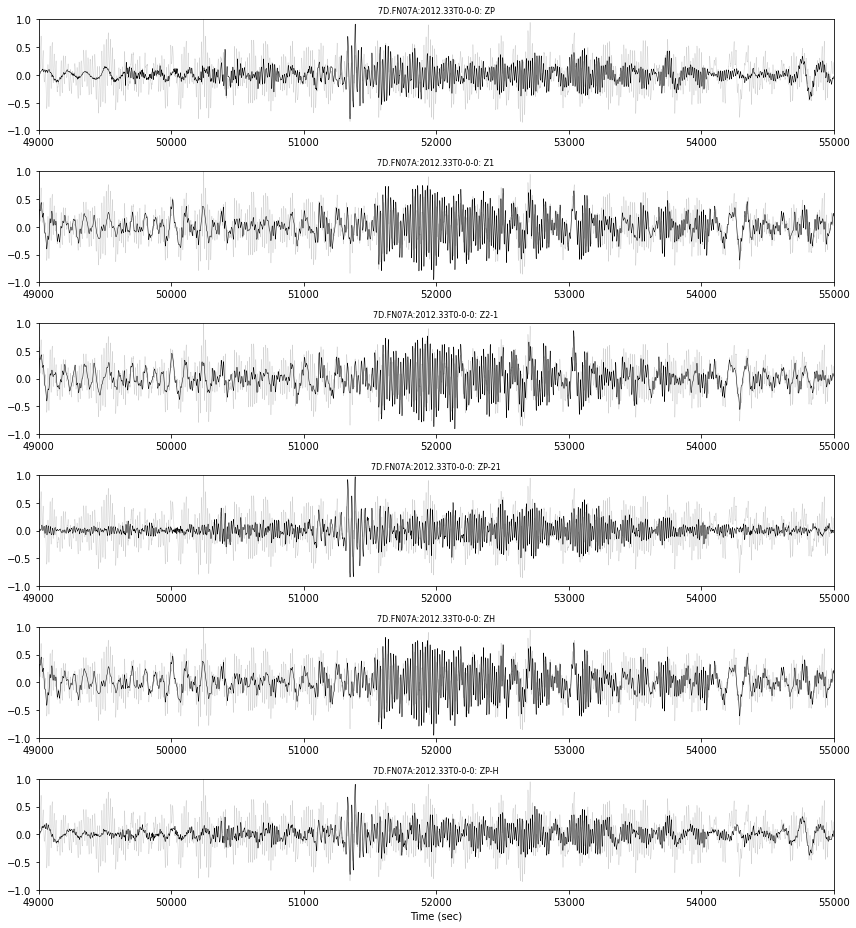

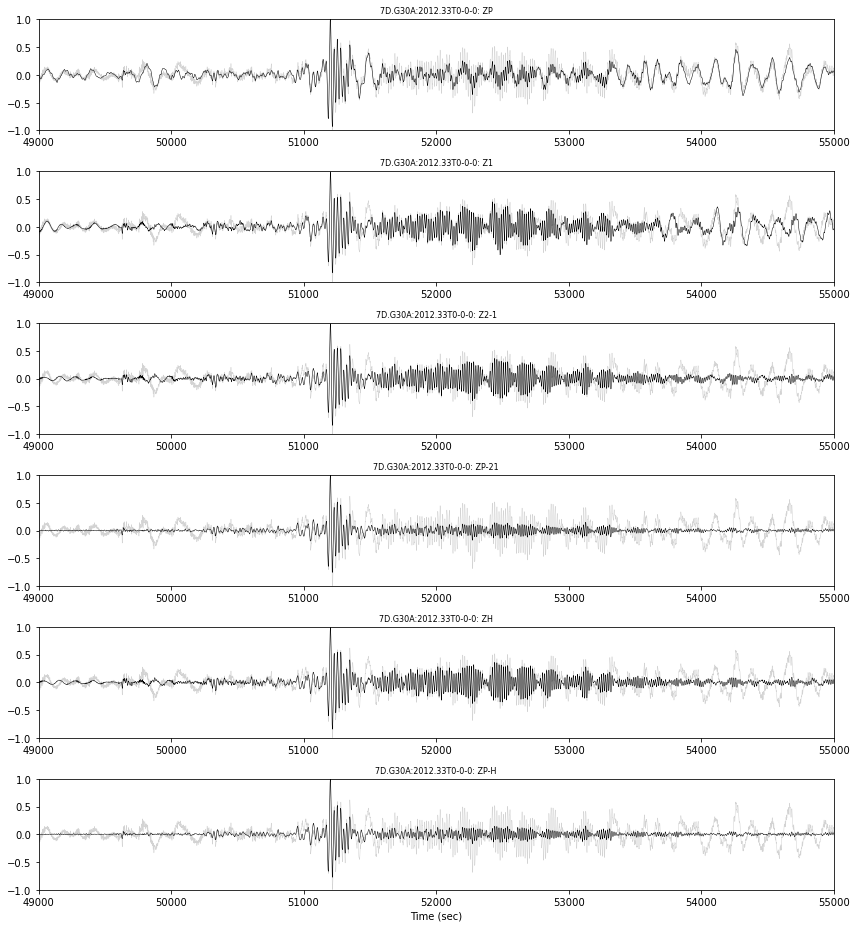

In [4]:
"""
Loop through stations
"""
savetofile=True
if savetofile:
    client=Client('IRIS')
    !rm *.h5
    
correctdictall=dict()
normalizecorrectionplot=True
for ista in stalist:
    t0=time.time()
    """
    a. Downloading data that will be used to compute the transfer functions.
    """
    tr1,tr2,trZ,trP = obs.getdata(net,ista,starttime,endtime,samp_freq=samp_freq,
                                  plot=False,rmresp=rmresp,pre_filt=pre_filt)
    ta=time.time() - t0
    """
    b. Call the wrapper to remove the tilt and compliance noise.
    """
    window=7200
    overlap=0.2
    taper=0.08
    
    correct=obs.TCremoval_wrapper(
        tr1,tr2,trZ,trP,window=window,overlap=overlap,merge_taper=taper,
        qc_freq=[0.004, 0.2],qc_spectra=True,fig_spectra=False,
        save_spectrafig=False,fig_transfunc=False)[2]
    correctdictall[net+"."+ista]=correct
    
    obs.plotcorrection(trZ,correct,normalize=normalizecorrectionplot,freq=[0.005,0.1],
                       size=(12,13),save=True,form='png',xlimit=[49000,55000])
        
    tb=time.time() - t0 - ta
    
    print('all cpu times:')
    print(ta,tb)

    """
    c. Save to ASDF file.
    """
    if savetofile:
        year = trZ.stats.starttime.year
        julday = trZ.stats.starttime.julday
        hour = trZ.stats.starttime.hour
        mnt = trZ.stats.starttime.minute
        sec = trZ.stats.starttime.second
        tstamp = str(year) + '.' + str(julday)+'T'+str(hour)+'-'+str(mnt)+'-'+str(sec)
        fnamebase = trZ.stats.network+'.'+trZ.stats.station+'_'+tstamp+'_LEN'+\
                    str(trZ.stats.endtime-trZ.stats.starttime)+'s'
        tags=[]
        for itr,tr in enumerate([tr1,tr2,trZ,trP],1):
            if len(tr.stats.location) == 0:
                tlocation='00'
            else:
                tlocation=tr.stats.location

            tags.append(tr.stats.channel.lower()+'_'+tlocation.lower())

        fnameraw=fnamebase+'_raw.h5'
        sta_inv=client.get_stations(network=net,station=ista,
                                    starttime=starttime,endtime=endtime,
                                    location='*',level='response')
        print('  saving raw data to '+fnameraw)
        utils.save2asdf(fnameraw,Stream(traces=[tr1,tr2,trZ,trP]),tags,sta_inv=sta_inv)

        fnamecorrect=fnamebase+'_corrected.h5'
        print('  saving corrected data to '+fnamecorrect)
        obs.savecorrection(trZ,correct,fname=fnamecorrect,subset=['ZP-H'],sta_inv=sta_inv,
                           format='asdf',debug=True)